# Neighbourhood Components Analysis (NCA) Method

In this notebook, we present the Neighbourhood Components Analysis (NCA) method for learning a Mahalanobis distance measure to be used in the the K Nearest Neighbors (K-NN) classification. 
https://cs.nyu.edu/~roweis/papers/ncanips.pdf

The NCA addresses two key limitations of K-NN:

- Computational: K-NN needs to store the entire training dataset and compute distance with all training points
- The absence of an optimal distance metric in K-NN


The NCA method addresses the above two limitations by "learning" a distance metric for a given problem. 

- NCA finds a linear transformation of input data such that the average leave-one-out (LOO) classification performance is maximized in the transformed space. 

- The learned distance metric of NCA is low rank, thus substantially reduces storage and search costs at test time.


The learned Mahalanobis distance measure of NCA is used by a K-NN classifier model. 


## Task

We compare the performance of the K-NN on the transformed feature space of NCA and the original feature space.  

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV


# Synthetic Dataset

We will use Scikit-Learn's "datasets.make_moons" function to generate a synthetic non-linear dataset that is suitable for investigating classification (as well as clustering) models. 

The following parameter is used by the make_moons function:

- noise : Standard deviation of Gaussian noise added to the data.

## Load The Data and Visualiize 

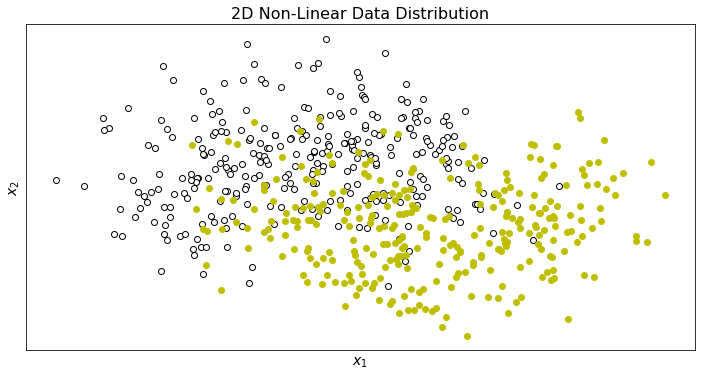

In [2]:
X, y = make_moons(n_samples=600, noise=0.45, random_state=0)

plt.figure(figsize=(12, 6))
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "wo", markeredgecolor="k")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")

plt.title("2D Non-Linear Data Distribution", fontsize=16)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.xticks(())
plt.yticks(())
plt.show()

# Create Training and Test Dataset

In [3]:
# Spilt the dataset into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(480, 2)
(120, 2)
(480,)
(120,)


## Standardize the Data

In [4]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Function for Plotting Decision Bounday 


To better understand how the K Nearest Neighbors model classifier performs classifiation, we need to **<font color=red size=6> visualize </font>** its decision boundary.


We define the function "decision_boundary_class_colored" to plot the decision boundary. 

In [5]:
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 0.1, X[:, 0].max() + 0.1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 0.1, X[:, 1].max() + 0.1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.RdGy, alpha=0.99)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    if(colorBar==True):
        plt.colorbar()    

## K-NN 

We find the optimal K-NN model by performing hyperparameter tuning.

In [6]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': np.arange(1,50), 'p': [1, 2, 10, 50, 100, 500, 1000], 
              'weights': ["uniform", "distance"]}

knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1', cv=5, verbose=3, n_jobs=-1)
knn_cv.fit(X_train, y_train)


params_optimal_knn = knn_cv.best_params_

print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 686 candidates, totalling 3430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1936 tasks      | elapsed:    3.8s


Best Score: 0.841482
Optimal Hyperparameter Values:  {'n_neighbors': 24, 'p': 1000, 'weights': 'uniform'}


CPU times: user 2.06 s, sys: 129 ms, total: 2.19 s
Wall time: 5.39 s


[Parallel(n_jobs=-1)]: Done 3430 out of 3430 | elapsed:    5.4s finished


In [7]:
knn = KNeighborsClassifier(**params_optimal_knn)
knn.fit(X_train, y_train)

# Compute accuracy on the training set
train_accuracy = knn.score(X_train, y_train)
print("\nKNN Train Accuracy: ", train_accuracy)

# Compute accuracy on the test set
test_accuracy = knn.score(X_test, y_test) 

print("\nKNN Test Accuracy: ", test_accuracy)


KNN Train Accuracy:  0.8291666666666667

KNN Test Accuracy:  0.825


## NCA

First, we transform the data using the NCA method. Then, we find the optimal K-NN model by performing hyperparameter tuning.

In [8]:
nca = NeighborhoodComponentsAnalysis(max_iter=100, random_state=0)
nca = nca.fit(X_train, y_train)

X_train_embedded = nca.transform(X_train)

X_test_embedded = nca.transform(X_test)

In [9]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': np.arange(1,50), 'p': [1, 2, 10, 50, 100, 500, 1000], 
              'weights': ["uniform", "distance"]}

knn_clf_nca = KNeighborsClassifier()

knn_cv_nca = GridSearchCV(knn_clf_nca, param_grid, scoring='f1', cv=5, verbose=3, n_jobs=-1)
knn_cv_nca.fit(X_train_embedded, y_train)


params_optimal_knn_nca = knn_cv_nca.best_params_

print("Best Score: %f" % knn_cv_nca.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn_nca)
print("\n")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 686 candidates, totalling 3430 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s


Best Score: 0.838540
Optimal Hyperparameter Values:  {'n_neighbors': 39, 'p': 50, 'weights': 'uniform'}


CPU times: user 2.34 s, sys: 76.7 ms, total: 2.41 s
Wall time: 4.05 s


[Parallel(n_jobs=-1)]: Done 3430 out of 3430 | elapsed:    4.0s finished



NCA+KNN Train Accuracy:  0.84375

NCA+KNN Test Accuracy:  0.8416666666666667


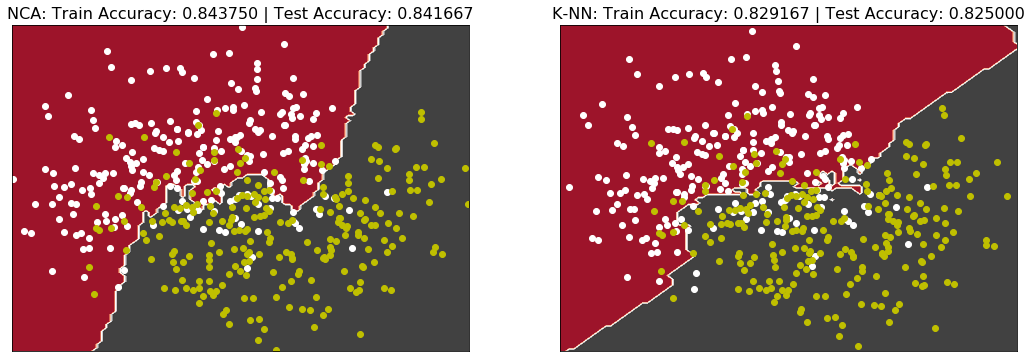

In [10]:
knn_nca = KNeighborsClassifier(**params_optimal_knn_nca)

knn_nca.fit(X_train_embedded , y_train)


# Compute accuracy on the training set
train_accuracy_nca = knn_nca.score(X_train_embedded, y_train)
print("\nNCA+KNN Train Accuracy: ", train_accuracy_nca)

# Compute accuracy on the test set
test_accuracy_nca = knn_nca.score(X_test_embedded, y_test)

print("\nNCA+KNN Test Accuracy: ", test_accuracy_nca)

# Show the decision boundary only on the training data
plt.figure(figsize=(18,6))

plt.subplot(121)
decision_boundary_class_colored(knn_nca, X_train_embedded, plotDistanceFromHyperplane=False)
plt.plot(X_train_embedded[y_train.ravel()==0, 0], X_train_embedded[y_train.ravel()==0, 1], "wo")
plt.plot(X_train_embedded[y_train.ravel()==1, 0], X_train_embedded[y_train.ravel()==1, 1], "yo")
plt.title("NCA: Train Accuracy: %f | Test Accuracy: %f"% 
              (train_accuracy_nca, test_accuracy_nca) , fontsize=16)
plt.xticks(())
plt.yticks(())


plt.subplot(122)
decision_boundary_class_colored(knn, X_train, plotDistanceFromHyperplane=False)
plt.plot(X_train[y_train.ravel()==0, 0], X_train[y_train.ravel()==0, 1], "wo")
plt.plot(X_train[y_train.ravel()==1, 0], X_train[y_train.ravel()==1, 1], "yo")
plt.title("K-NN: Train Accuracy: %f | Test Accuracy: %f"% 
              (train_accuracy, test_accuracy) , fontsize=16)
plt.xticks(())
plt.yticks(())


plt.show()

# Observation

The above plot shows the class decision boundaries created by a K-NN classifier when using the Minkowski distance on the original features, versus using the Minkowski distance after the transformation learned by NCA. 

We observe that NCA finds a linear transformation of the features that maximises the (stochastic) nearest neighbor classification accuracy on the training set as well as on the test set.